In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, 
    f1_score, roc_auc_score, confusion_matrix, roc_curve
)
from imblearn.over_sampling import SMOTE
import joblib
import os

In [13]:
# Set style for plots
sns.set_style("whitegrid")
plt.rcParams["figure.figsize"] = (12, 6)

In [14]:
file_path = r"C:\ecommerce_churn_prediction\data\processed\preprocessed_data.csv"
df = pd.read_csv(file_path)

In [15]:
# Ensure all columns are numeric (drop non-numeric if any)
df = df.select_dtypes(include=[np.number])

In [16]:
# Split features and target
X = df.drop(columns=["Churn"])
y = df["Churn"]

In [17]:
# Encode labels (if not already encoded as 0 and 1)
le = LabelEncoder()
y_encoded = le.fit_transform(y)

In [18]:
# --- Split Data ---
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, 
    test_size=0.2, 
    random_state=42, 
    stratify=y_encoded
)

In [19]:
# --- Handle Class Imbalance with SMOTE ---
smote = SMOTE(random_state=42)
X_train_bal, y_train_bal = smote.fit_resample(X_train, y_train)
print("Class Distribution After SMOTE:", pd.Series(y_train_bal).value_counts())


Class Distribution After SMOTE: 0    3746
1    3746
Name: count, dtype: int64


In [20]:
# --- Model 1: Optimized Logistic Regression ---
logistic_param_grid = {
    'C': [0.01, 0.1, 1, 10],
    'solver': ['liblinear', 'saga'],
    'class_weight': [None, 'balanced']
}

In [21]:
logistic_grid = GridSearchCV(
    LogisticRegression(max_iter=1000, random_state=42),
    param_grid=logistic_param_grid,
    scoring='roc_auc',
    cv=5,
    n_jobs=-1
)

In [22]:
logistic_grid.fit(X_train_bal, y_train_bal)
best_logistic = logistic_grid.best_estimator_

In [23]:
# --- Model 2: Optimized Random Forest ---
rf_param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'class_weight': [None, 'balanced']
}

In [24]:
rf_grid = GridSearchCV(
    RandomForestClassifier(random_state=42),
    param_grid=rf_param_grid,
    scoring='roc_auc',
    cv=3,
    n_jobs=-1
)

In [25]:
rf_grid.fit(X_train_bal, y_train_bal)
best_rf = rf_grid.best_estimator_

In [26]:
# --- Model 3: Optimized XGBoost ---
scale_pos_weight = (len(y_train_bal) - sum(y_train_bal)) / sum(y_train_bal)

In [27]:
xgb_param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1]
}

In [28]:
xgb_grid = GridSearchCV(
    XGBClassifier(
        random_state=42,
        scale_pos_weight=scale_pos_weight,
        eval_metric='logloss'
    ),
    param_grid=xgb_param_grid,
    scoring='roc_auc',
    cv=3,
    n_jobs=-1
)

In [29]:
xgb_grid.fit(X_train_bal, y_train_bal)
best_xgb = xgb_grid.best_estimator_

In [30]:
# --- Evaluate All Models ---
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]
    
    metrics = {
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred),
        'Recall': recall_score(y_test, y_pred),
        'F1': f1_score(y_test, y_pred),
        'ROC-AUC': roc_auc_score(y_test, y_proba)
    }
    
    # Confusion Matrix
    plt.figure()
    sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
    plt.title(f"{model.__class__.__name__} Confusion Matrix")
    plt.show()
    
    # ROC Curve
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    plt.figure()
    plt.plot(fpr, tpr, label=f'AUC = {metrics["ROC-AUC"]:.2f}')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f"{model.__class__.__name__} ROC Curve")
    plt.legend()
    plt.show()
    
    return metrics



Logistic Regression Performance:


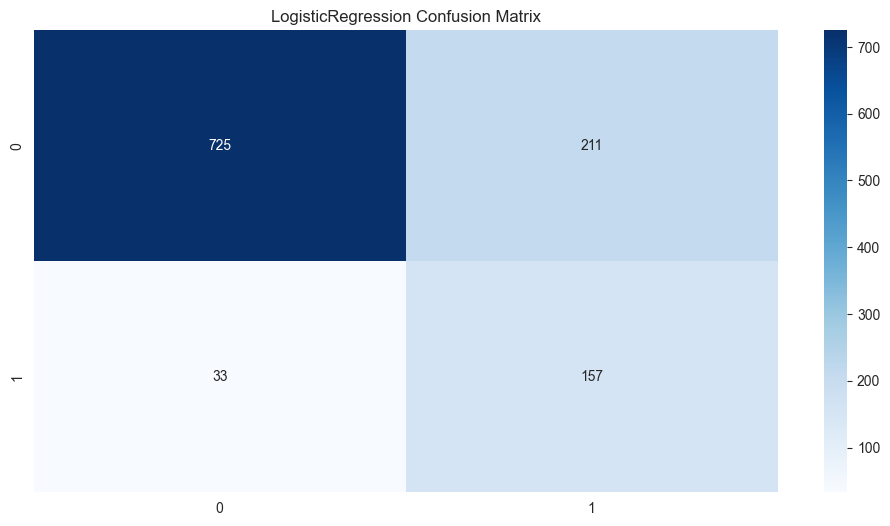

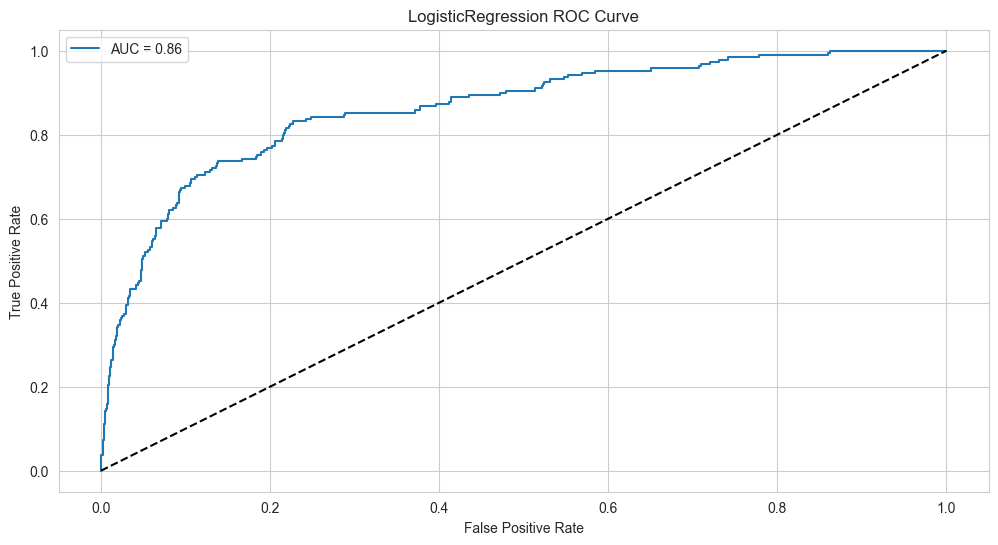

Accuracy     0.783304
Precision    0.426630
Recall       0.826316
F1           0.562724
ROC-AUC      0.863107


In [31]:
# Evaluate Logistic Regression
print("\n" + "="*40)
print("Logistic Regression Performance:")
log_metrics = evaluate_model(best_logistic, X_test, y_test)
print(pd.Series(log_metrics).to_string())


Random Forest Performance:


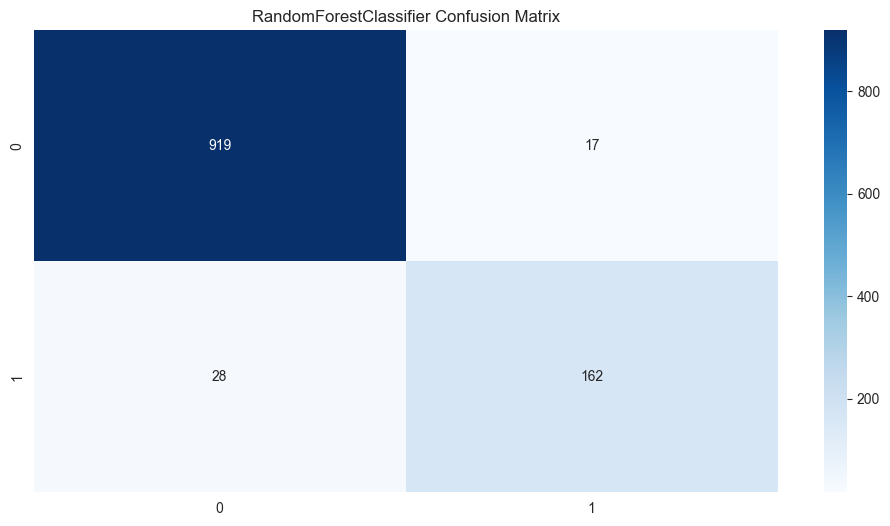

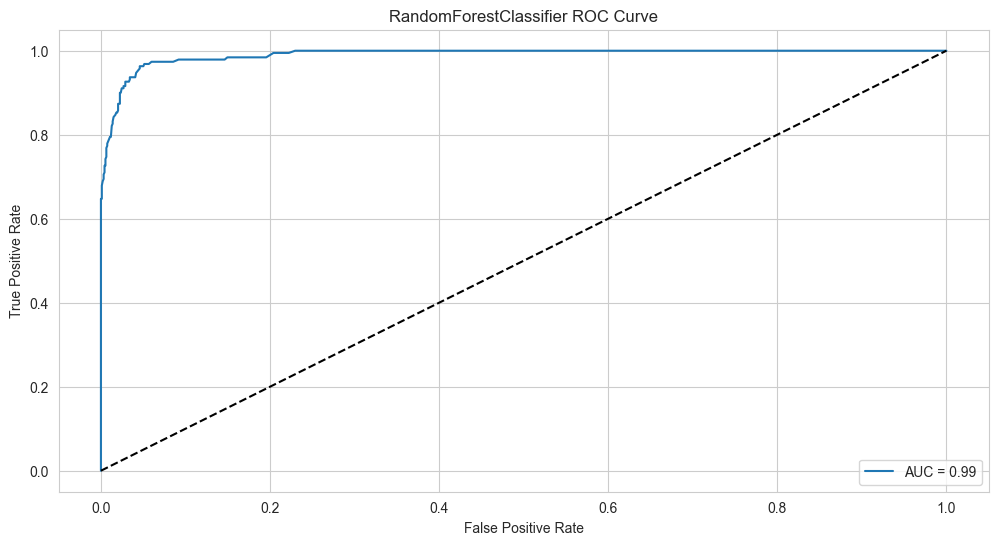

Accuracy     0.960036
Precision    0.905028
Recall       0.852632
F1           0.878049
ROC-AUC      0.990233


In [32]:
# Evaluate Random Forest
print("\n" + "="*40)
print("Random Forest Performance:")
rf_metrics = evaluate_model(best_rf, X_test, y_test)
print(pd.Series(rf_metrics).to_string())


XGBoost Performance:


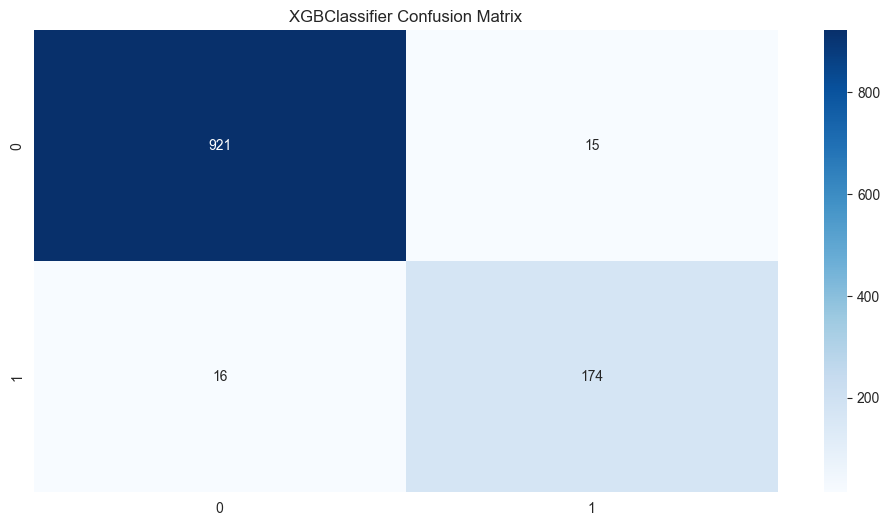

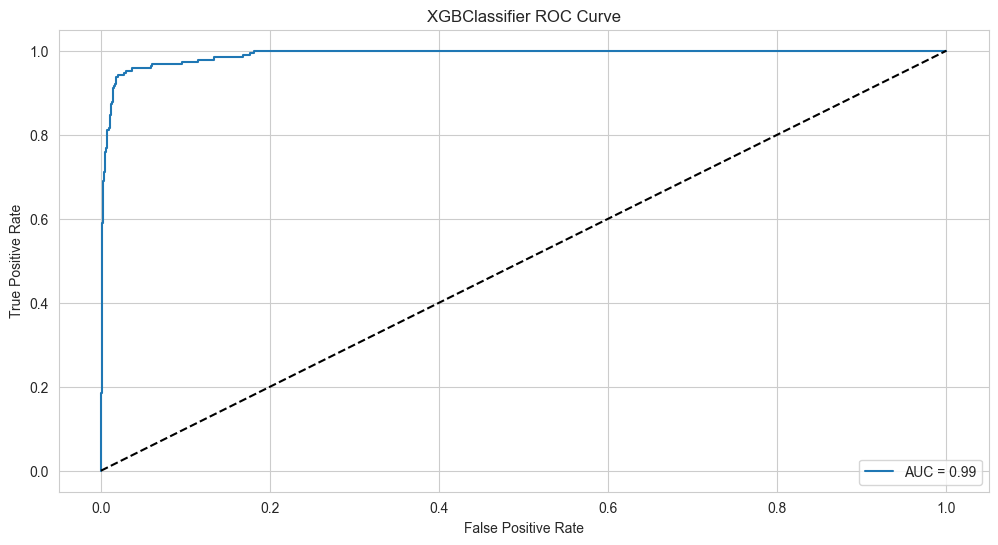

Accuracy     0.972469
Precision    0.920635
Recall       0.915789
F1           0.918206
ROC-AUC      0.991228


In [33]:
# Evaluate XGBoost
print("\n" + "="*40)
print("XGBoost Performance:")
xgb_metrics = evaluate_model(best_xgb, X_test, y_test)
print(pd.Series(xgb_metrics).to_string())


In [34]:
# --- Save Best Model ---
model_path = r"C:\ecommerce_churn_prediction\models"
if not os.path.exists(model_path):
    os.makedirs(model_path)

In [36]:
# Select Best Model (Change to best_rf or best_logistic if needed)
best_model = best_xgb
model_save_path = os.path.join(model_path, "best_model.pkl")
joblib.dump(best_model, model_save_path)
print(f"\nBest model saved to {model_save_path}")


Best model saved to C:\ecommerce_churn_prediction\models\best_model.pkl


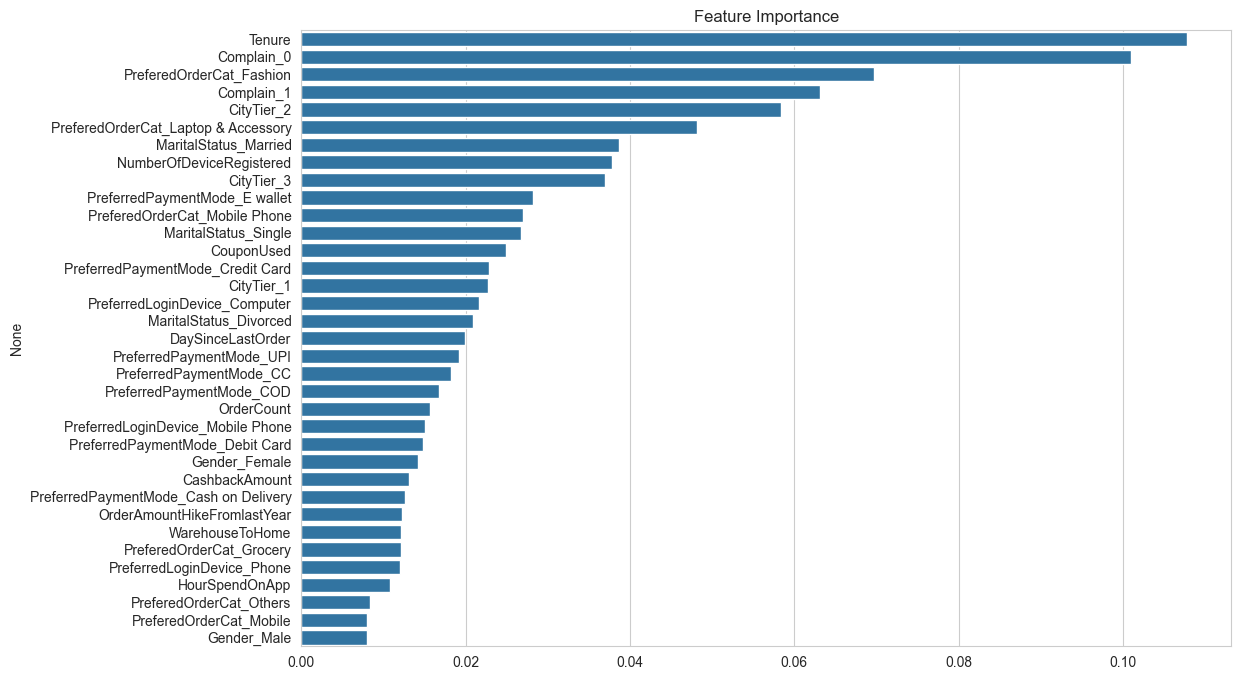

In [37]:
# --- Feature Importance (For Tree-Based Models) ---
if hasattr(best_model, 'feature_importances_'):
    feature_importance = pd.Series(
        best_model.feature_importances_,
        index=X.columns
    ).sort_values(ascending=False)
    
    plt.figure(figsize=(12, 8))
    sns.barplot(x=feature_importance.values, y=feature_importance.index)
    plt.title("Feature Importance")
    plt.show()